### Setting Up Standard Imports

In [218]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing Clean Data

In [58]:
corpus = pd.read_csv('data/cleaned.csv')
corpus.drop(columns='Unnamed: 0', inplace=True)
corpus

,body,target,company
0,"['wesley', 'i', 'have', 'a', 'g', 'iphone', 'a...",0,apple
1,"['jessedee', 'know', 'about', 'fludapp', 'awes...",2,apple
2,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...",2,apple
3,"['sxsw', 'i', 'hope', 'this', 'year', 'festiva...",0,apple
4,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...",2,google
...,...,...,...
8158,"['ipad', 'everywhere', 'sxsw', 'link']",2,apple
8159,"['wave', 'buzz', 'rt', 'mention', 'we', 'inter...",1,google
8160,"['google', 'zeiger', 'a', 'physician', 'never'...",1,google
8161,"['some', 'verizon', 'iphone', 'customer', 'com...",1,apple


### Setting Up Train-Test-Split for Modeling

In [100]:
X = corpus.body
y = corpus.target

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [102]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

### Using Count Vectorizer 

In [133]:
cv = CountVectorizer()

In [134]:
X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [135]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### Dummy Model

In [166]:
from sklearn.dummy import DummyClassifier

In [170]:
dum = DummyClassifier(strategy='most_frequent')

In [171]:
dum.fit(X_t_vec, y_t)

DummyClassifier(strategy='most_frequent')

In [173]:
ydum_hat = dum.predict(X_val)

In [175]:
accuracy_score(y_val, y_hat)

0.6636185499673416

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


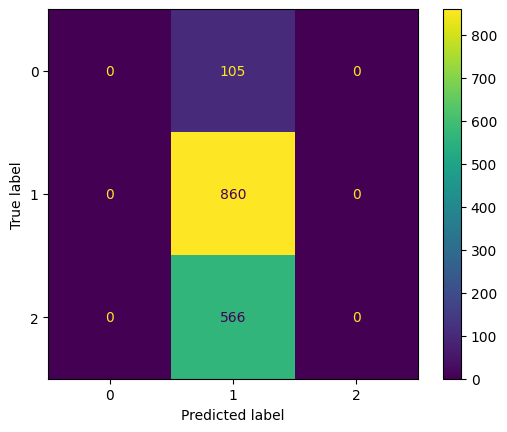

In [209]:
plot_confusion_matrix(dum, X_val, y_val)

### First Model -- Multinomial Naive Bayes with count vectorizer

In [106]:
baseline_model = MultinomialNB()

In [107]:
baseline_model.fit(X_t_vec, y_t)

MultinomialNB()

In [108]:
y_hat = mnb.predict(X_val_vec)

In [109]:
# from sklearn.model_selection import cross_val_score

In [110]:
# baseline_cv = cross_val_score(baseline_model, X_t_vec, y_t)

In [111]:
# baseline_cv.mean()

In [112]:
y_t.value_counts(normalize=True)

1    0.568068
2    0.361359
0    0.070573
Name: target, dtype: float64

If we were to predict the majority class of 1 every time we would have an accuracy of 56%. Our baseline model has an accuracy score of 67%, which is already better than just pure guessing. 

In [113]:
accuracy_score(y_val, y_hat)

0.6681907250163291

In [114]:
precision_score(y_val, y_hat, average='weighted')

0.6651654026030132

In [115]:
cm = confusion_matrix(y_val, y_hat)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


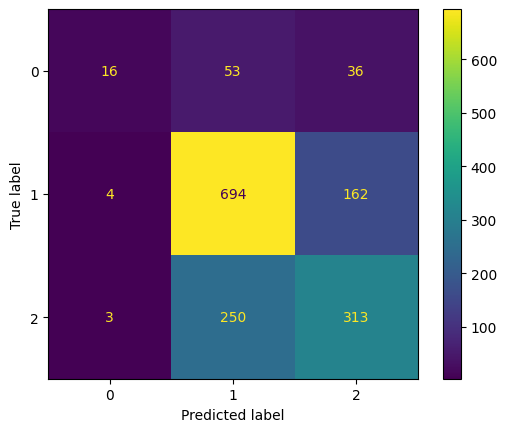

In [116]:
plot_confusion_matrix(baseline_model, X_val_vec, y_val)

### Second Model -- MNB with TFIDF vectorizer

In [121]:
tfidf = TfidfVectorizer()
X_t_vec2 = tfidf.fit_transform(X_t)

In [122]:
X_val_vec2 = tfidf.transform(X_val)

In [123]:
mnb2 = MultinomialNB()
mnb2.fit(X_t_vec2, y_t)
y_hat2 = mnb2.predict(X_val_vec2)

In [124]:
accuracy_score(y_val, y_hat2)

0.6322664924885696

In [125]:
precision_score(y_val, y_hat2, average='weighted')

0.6619608875256795

Score decreased with TFIDF vectorizer, will continue to test with both types of vectors with RF model to compare scores.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


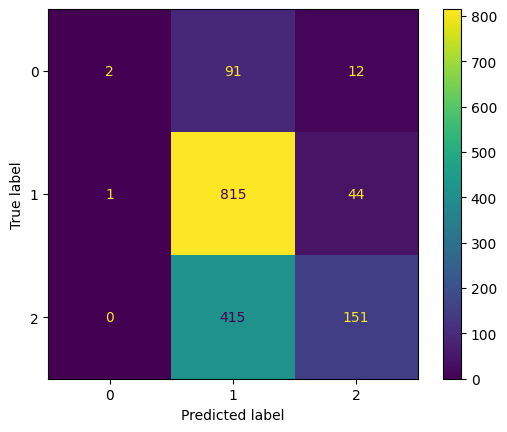

In [127]:
plot_confusion_matrix(mnb2, X_val_vec2, y_val)

### Third Model -- Random Forests with Count vectorizer

In [188]:
cv2 = CountVectorizer()

In [189]:
X_t_vec3 = cv.fit_transform(X_t)

In [190]:
X_val_vec3 = cv.transform(X_val)

In [191]:
rf = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [192]:
rf.fit(X_t_vec3, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [193]:
y_hat3 = rf.predict(X_val_vec3)
precision_score(y_val, y_hat3, average='weighted')

0.6726041025220305

In [194]:
accuracy_score(y_val, y_hat3)

0.6636185499673416

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


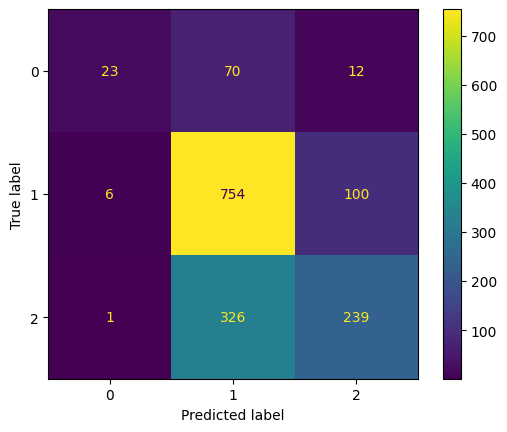

In [195]:
plot_confusion_matrix(rf, X_val_vec3, y_val)

### Fourth Model with Random Forests and TFIDF

In [202]:
tfidf2 = TfidfVectorizer()
X_t_vec4 = tfidf2.fit_transform(X_t)

In [203]:
X_val_vec4 = tfidf2.transform(X_val)

In [204]:
rf2 = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [205]:
rf2.fit(X_t_vec4, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [206]:
y_hat4 = rf2.predict(X_val_vec4)
precision_score(y_val, y_hat4, average='weighted')

0.6734199439532742

In [207]:
accuracy_score(y_val, y_hat4)

0.6662312214239059

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


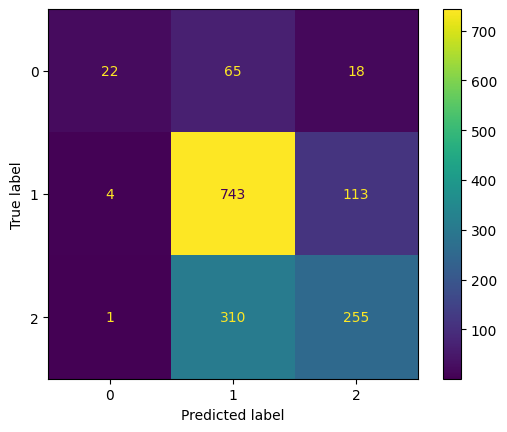

In [208]:
plot_confusion_matrix(rf2, X_val_vec4, y_val)

### Baseline Model Evalution
Of our 4 baseline models, the best performing was model 4 -- TFIDF with Random Forests. It had an overall accuracy of 66.6% and a precision score of 67.3%. We are choosing this model to run with our test data.

### Grid Searching for best parameters

In [224]:
rf = RandomForestClassifier()

params = {}
params['max_features'] = ['sqrt', 'log2']
params['n_estimators'] = [10, 100, 1000]

In [225]:
grid_search = GridSearchCV(
    rf, 
    param_grid=params, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=10
)

grid_result = grid_search.fit(X_t_vec, y_t)

# summarization
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: 0.658899 using {'max_features': 'sqrt', 'n_estimators': 100}
0.629276 (0.008301) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.658899 (0.019472) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.655414 (0.014670) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.615116 (0.012759) with: {'max_features': 'log2', 'n_estimators': 10}
0.640821 (0.010481) with: {'max_features': 'log2', 'n_estimators': 100}
0.642563 (0.013926) with: {'max_features': 'log2', 'n_estimators': 1000}
[CV 1/5; 1/6] START max_features=sqrt, n_estimators=10..........................
[CV 1/5; 1/6] END max_features=sqrt, n_estimators=10;, score=0.622 total time=   0.5s
[CV 1/5; 3/6] START max_features=sqrt, n_estimators=1000........................
[CV 1/5; 3/6] END max_features=sqrt, n_estimators=1000;, score=0.652 total time=  56.6s
[CV 2/5; 2/6] START max_features=sqrt, n_estimators=100.........................
[CV 2/5; 2/6] END max_fe

### Changing min & max df

**min_df** is used for removing terms that appear too infrequently. For example:

**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
**min_df** = 5 means "ignore terms that appear in less than 5 documents".
The default **min_df** is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
**max_df** = 25 means "ignore terms that appear in more than 25 documents".
The default **max_df** is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

In [318]:
tfidf3 = TfidfVectorizer(max_df=0.95)

In [319]:
X_t_vec5 = tfidf3.fit_transform(X_t)

In [320]:
X_val_vec5 = tfidf3.transform(X_val)

In [321]:
rf3 = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [322]:
rf3.fit(X_t_vec5, y_t)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [323]:
y_hat5 = rf3.predict(X_val_vec5)


In [324]:
precision_score(y_val, y_hat5, average='weighted')

0.675825538436873

In [325]:
accuracy_score(y_val, y_hat5)

0.6688438928804703

Changing the min_df essentially had no effect on the accuracy or precision of the model. But changing max_df from the default of 1.0 to 0.95 increased the model's precision to 67.6% and the accuracy score to 66.9%.

### Model Evaluation on Test Set

In [326]:
final_tfidf = TfidfVectorizer(max_df=0.95)
X_vec_train_final = final_tfidf.fit_transform(X_train)
X_vec_test_final = final_tfidf.transform(X_test)

In [327]:
final_model = RandomForestClassifier(random_state=42, 
                            n_estimators=1000, 
                            max_features= 'sqrt')

In [330]:
final_model.fit(X_vec_train_final, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [331]:
final_model.score(X_vec_train_final, y_train)

0.9950996406403136

In [335]:
y_hat_final = final_model.predict(X_vec_test_final)

In [334]:
final_model.score(X_vec_test_final, y_test)

0.6629103380695738

In [336]:
precision_score(y_test, y_hat_final, average='weighted')

0.6549667246335075

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


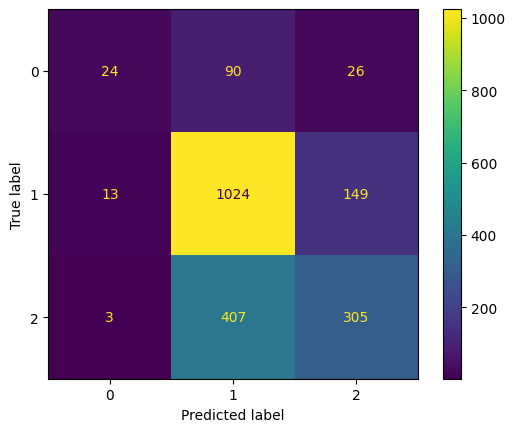

In [337]:
plot_confusion_matrix(final_model, X_vec_test_final, y_test)

### Word Cloud Analysis

In [340]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.8.2.2-cp310-cp310-macosx_10_9_universal2.whl size=218380 sha256=247d2e677fa10f7f77c9f97ba6074ded11dbb08ffd08250faafadb7de08b2193
  Stored in directory: /Users/ashlidougherty/Library/Caches/pip/wheels/30/52/73/36458d38e3c533678a3043949ad72658025d8e89d942439d49
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


In [341]:
from wordcloud import WordCloud

In [342]:
import matplotlib as plt

In [344]:
def generate_wordcloud(corpus, collocations = False, background_color ='black',
                      colormap='Greens', display = True):
    wordcloud = WordCloud(collocations=collocations, background_color=background_color,
                         colormap=colormap, width=500, height=300)
    wordcloud.generate(','.join(corpus))
    
    if display:
        plt.figure(figsize= (12,15), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis('off');
    return wordcloud